# Qaintellect VQT Example
In this example, we implement the optimization of a circuit based on a proposed VQT algorithm by Verdon et al. 
[1] demonstrated parametrization of a thermal state in terms of a quantum circuit.

In [1]:
include("../src/Qaintellect.jl")
using .Qaintellect

using Qaintessent, Flux, LinearAlgebra, Test, Plots
using Flux.Optimise: update!
using IterTools: ncycle

In [12]:
N = 4
I2 = I + zeros(ComplexF64, 2,2)
S_vec = [0.5*Qaintessent.matrix(XGate()), 0.5*Qaintessent.matrix(YGate()), 0.5*Qaintessent.matrix(ZGate())]
# S[i][j] is
# jth Spin operator at i-th qubit
# e.g., S[2][3] = I ⊗ Z/2 ⊗ I ⊗ I
S1 = [kron(spin, I2, I2, I2) for spin in S_vec]
S2 = [kron(I2, spin, I2, I2) for spin in S_vec]
S3 = [kron(I2, I2, spin, I2) for spin in S_vec]
S4 = [kron(I2, I2, I2, spin) for spin in S_vec]
S = [S1, S2, S3, S4]

4-element Array{Array{Array{Complex{Float64},2},1},1}:
 [[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.5 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.5 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … -0.5 + 0.0im -0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … -0.0 + 0.0im -0.5 + 0.0im]]
 [[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0

In [3]:
# Model parameters for 2x2 VQT
# q1 q2
# q3 q4
# (1,2) and (3,4) are horizontally bonded
# (1,3) and (2,4) are horizontally bonded
β = 2.6
J_h = 1.0
J_v = 0.6
# two-dimensional Heisenberg model Hamiltonian
H_heis = J_h* (+([S1[i]*S2[i] + S3[i]*S4[i] for i in 1:3]...)) + J_v* (+([S1[i]*S3[i] + S2[i]*S4[i] for i in 1:3]...))
# Analytically, we can compute the target thermal state by eigenvalue decomposition.
# Here, we just exploit exp function for matrices.
target_state = exp(-β*H_heis) / tr(exp(-β*H_heis))

16×16 Array{Complex{Float64},2}:
 0.00114076+0.0im           0.0+0.0im  …         0.0+0.0im         0.0+0.0im
        0.0-0.0im     0.0237546+0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im    -0.0204699+0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im    5.0304e-18-0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im    -0.0155048+0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im   3.76876e-18-0.0im  …         0.0+0.0im         0.0+0.0im
        0.0-0.0im   7.04977e-18-0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im           0.0-0.0im      0.0133608+0.0im         0.0+0.0im
        0.0-0.0im     0.0133608-0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im  -7.05416e-18+0.0im            0.0+0.0im         0.0+0.0im
        0.0-0.0im           0.0-0.0im  …         0.0+0.0im         0.0+0.0im
        0.0-0.0im           0.0-0.0im     -0.0155048+0.0im         0.0+0.0im
        0.0-0.0im  -3.97163e-19+0.0im      

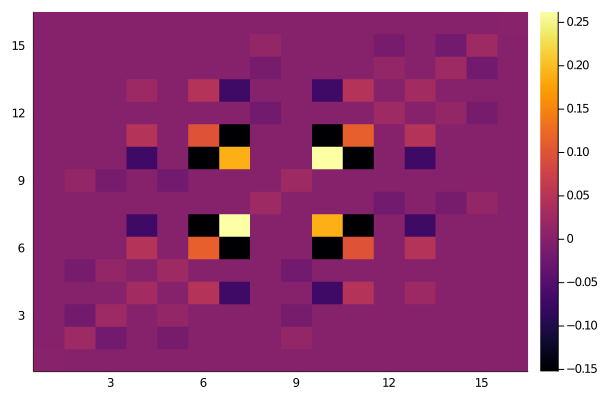

In [4]:
heatmap(real(target_state))

In [5]:
cgc = CircuitGateChain{N}(
    [
        single_qubit_circuit_gate(1, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(2, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(3, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(4, RotationGate(rand(Float64,3)), N),
        controlled_circuit_gate(1, 2, RxGate(rand(Float64,1)...), N),
        controlled_circuit_gate(3, 4, RxGate(rand(Float64,1)...), N),
        single_qubit_circuit_gate(1, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(2, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(3, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(4, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(1, RotationGate(rand(Float64,3)), N),
        controlled_circuit_gate(2, 3, RxGate(rand(Float64,1)...), N),
        single_qubit_circuit_gate(4, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(1, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(2, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(3, RotationGate(rand(Float64,3)), N),
        single_qubit_circuit_gate(4, RotationGate(rand(Float64,3)), N),
        controlled_circuit_gate(1, 2, RxGate(rand(Float64,1)...), N),
        controlled_circuit_gate(3, 4, RxGate(rand(Float64,1)...), N),
    ]
)


    4 —[Rθ]———•————[Rθ]——[Rθ]——[Rθ]———•———
              |                       |   
    3 —[Rθ]——[Rx]——[Rθ]———•————[Rθ]——[Rx]—
                          |               
    2 —[Rθ]———•————[Rθ]——[Rx]——[Rθ]———•———
              |                       |   
    1 —[Rθ]——[Rx]——[Rθ]——[Rθ]——[Rθ]——[Rx]—


In [6]:
meas_op = H_heis
meas = MeasurementOps{N}([meas_op])
c = Circuit{N}(cgc, meas)


    4 —[Rθ]———•————[Rθ]——[Rθ]——[Rθ]———•———
              |                       |   
    3 —[Rθ]——[Rx]——[Rθ]———•————[Rθ]——[Rx]—
                          |               
    2 —[Rθ]———•————[Rθ]——[Rx]——[Rθ]———•———
              |                       |   
    1 —[Rθ]——[Rx]——[Rθ]——[Rθ]——[Rθ]——[Rx]—


In [40]:
θ = rand(Float64, N)-0.5*ones(Float64, N)
sigmoid(z::Real) = 1.0 / (1.0 + exp(-z))
multinoulli(ps) = kron([[p, 1-p] for p in ps]...) # Returns Multi-noulli distribution with probability pθ(x) for each |x> in xs
II = kron([I2 for i in 1:N]...)
xs = [II[i,:] for i in 1:2^N] # standard basis

16-element Array{Array{Complex{Float64},1},1}:
 [1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0

In [50]:
function entropy(dist)
    reduce(+ ,map(dist) do x
        if abs(x) <= 0
            return 0
        else
            return -abs(x) * log(abs(x))
        end
    end
    )
end
loss() = β * sum([multinoulli(sigmoid.(θ))[i]* apply(c, xs[i]) for i in 1:N^2])[1] - entropy(multinoulli(sigmoid.(θ)))

loss (generic function with 1 method)

In [51]:
paras = Flux.params(c, θ)
opt = Descent(1.5)

Descent(1.5)

In [52]:
gs = gradient(() -> loss(), paras)

ErrorException: Can't differentiate loopinfo expression

[1] G. Verdon, J. Marks, S. Nanda, S. Leichenauer, J. Hidary, "Quantum Hamiltonian-Based Models and the Variational Quantum Thermalizer Algorithm",
https://arxiv.org/abs/1910.02071.